# Jupyter notebook for downloading ERA5 data

ERA5 is the global reanalysis version 5 produced by the European Centre for Medium-Range Weather Forecasting (ECMWF). A reanalysis builds upon a weather forecasting system, which means it uses a variety of satellite and in-situ datasets to estimate initial conditions ("analysis") and advances the initial state forward in time with a numerical model ("forecast"). In contrast to operational forecasts, one consistent model version is used for the entire reanalysis period (ERA5: 1940 - present), and more data can be "assimilated" as not all measurements are available in realtime. ERA5 has been run at a resolution of 25 km with 137 vertical levels. Data are stored with hourly time resolution. 

**Exercise: Estimate the data volume of a single variable!**

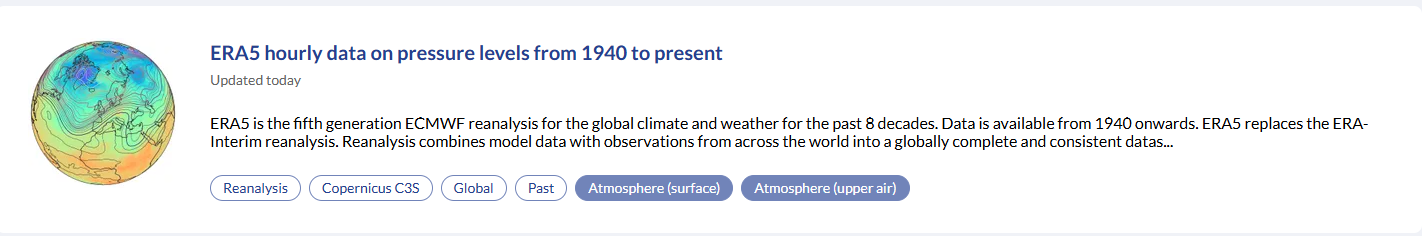

## Content of this notebook

This notebook explains how you can get access to ERA5 data and how you can download a custom-tailored subset of this dataset using ECMWF's Copernicus Data Store API and MARS system. This is only a demonstration. Before putting this knowledge to actual use, you should read the documentation of the CDS API and MARS to avoid unnecessary or overly costly queries. Furthermore, you should understand the basics of a reanalysis, what the different datasets that are derived from ERA5 actually mean, and what you really require.

For the purpose of this notebook, we assume that we would like to train ML models on subsets of ERA5 data. For this, we should retrieve snapshots of individual variables on single pressure levels at 12-hourly resolution. Specifically, we want to obtain the following data:

* spatial domain: global
* resolution: 5.625 degrees
* temporal extent: April 2021
* time resolution: 12-hourly
* variables: temperature, humidity, vorticity, divergence, geopotential
* vertical levels (pressure levels): surface, 850 hPa, 700 hPa, 500 hPa

**Exercise: estimate the data volume that you will download**

## How to proceed

1. Read through the [ERA5 documentation](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-complete?tab=form) to understand the data structure and identify which data/access point we need.
2. Install the [CDS API](https://cds.climate.copernicus.eu/how-to-api).
   * For this, we first need to register at [Copernicus Data Store](https://accounts.ecmwf.int/auth/realms/ecmwf/protocol/openid-connect/auth?client_id=cds&scope=openid%20email&response_type=code&redirect_uri=https%3A%2F%2Fcds.climate.copernicus.eu%2Fapi%2Fauth%2Fcallback%2Fkeycloak&state=eSFj1D686DwLjXr9KQRyDdS8UA1dAVnzsJzSvXQTetM&code_challenge=nf66xbC6c-X_rt1RIoT4al-fNscBETZhfSzP0i1DSbc&code_challenge_method=S256).
   * Next, copy and store your API key in file `$HOME/.cdsapirc`. You find it at the bottom of your personal profile when you are logged in to the CDS. Format of the `.cdsapirc` file:

```
url: https://cds.climate.copernicus.eu/api
key: {your-api-key-here}
```

3. Install the CDS API via `pip install cdsapi`
4. Read through the [instructions](https://cds.climate.copernicus.eu/api-how-to) on how to use the cdsapi (bottom half of the web page).
5. Browse through the [ERA5 data catalogue](https://apps.ecmwf.int/data-catalogues/era5/?class=ea) and select the fields you want to download.
6. After composing your search, click on "Show API request" and copy the commands into your notebook.

**
Please make sure to limit the download to 5.625 degree resolution and 12-hourly samples**
 Select Netcdf as output format.
 

In [ ]:
# install modules
!pip install --user cdsapi
# !pip install xarray

In [ ]:
import sys 
local_lib = '/p/home/jusers/schultz1/jsccloud/.local/lib/python3.12/site-packages/'

print(local_lib in sys.path)
if not (local_lib in sys.path):
    sys.path.append(local_lib)

In [ ]:
# Exemplary MARS request after composing through the web interface
# shortened from 1 month to 3 days for this demo
import cdsapi

c = cdsapi.Client()

c.retrieve("reanalysis-era5-complete", {
    "class": "ea",
    "date": "2021-04-01/to/2021-04-03",
    "expver": "1",
    "levelist": "500/700/850/1000",
    "levtype": "pl",
    "param": "129.128/130.128/133.128/138.128/155.128",
    "step": "6",
    "stream": "oper",
    "time": "06:00:00/18:00:00",
    "type": "fc"
}, "output")
# if successful, you shall see a new file named ```output``` in your current directory.


In [ ]:
# Try opening the retrieved data with xarray
import xarray as xr
ds = xr.open_dataset('output')
print(ds)

Too bad! What went wrong?

In [ ]:
# %load secrets/answer1.txt
The format of the `outout` file is grib, a special format for gridded data that is used by meteorological services.
The xarray library cannot handle grib files.

But didn't we say that we wanted to get the data as netcdf?

Well, let us inspect the MARS request again: it doesn't specify an output format, thus it reverts to the default grib.

While we are fixing things: what else is wrong?

We were estimating a file size of 10 MBytes for the whole month, but instead we download 100 MBytes for 3 days!!

We did not specify the output resolution.

The two things that we need to add to the request are thus:
"grid": "5.625/5.625",
"format": "netcdf"

Then, let us also choose a proper filename which allows us to identify the content of this dataset later.

In [ ]:
c.retrieve("reanalysis-era5-complete", {
    "class": "ea",
    "date": "2021-04-01/to/2021-04-03",
    "expver": "1",
    "levelist": "500/700/850/1000",
    "levtype": "pl",
    "param": "129.128/130.128/133.128/138.128/155.128",
    "step": "6",
    "stream": "oper",
    "time": "06:00:00/18:00:00",
    "type": "fc",
    "grid": "5.625/5.625",
    "format": "netcdf"
    }, "era5_ml_20210401-20210403.nc")

In [ ]:
# Try opening the retrieved data with xarray
import xarray as xr
ds = xr.open_dataset('era5_ml_20210401-20210403.nc')
print(ds)

In [ ]:
# Let us inspect the time steps that we retrieved
print(ds['valid_time'])

In [ ]:
%matplotlib inline
# and produce a simple plot of the 1000 hPa temperature field
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Select data for pressure level 1000 hPa (index 0, since pressure_level[0] = 1000.0)
# and valid_time on April 3, 2021 at 00:00
t_data = ds['t'].sel(
    pressure_level=1000.0,
    valid_time='2021-04-03T00:00:00'
)

# Create the plot with Robinson projection
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson())

# Plot the temperature field
cf = t_data.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  # Data is in PlateCarree (lon/lat)
    cmap='coolwarm',
    cbar_kwargs={'label': 'Temperature (K)'},
    add_colorbar=True,
    add_labels=False  # Avoid duplicate labels
)

# Set title
ax.set_title('Temperature at 1000 hPa on 2021-04-03 00:00 UTC', fontsize=14, pad=20)

# Add coastlines and country borders
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':')
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.OCEAN, color='lightblue')

# Set global view
ax.set_global()

# Improve layout
plt.tight_layout()


Wonderful - this was a success!

## Follow-up topics

### Efficiency of MARS requests

Even if we extract only coarse-resolution data and few variables etc., the data archival system needs to access several large files that are distributed across different tapes and/or disks. For anything that goes beyond a small toy example, it is therefore relevant to understand how the files can be accessed most efficiently. See [MARS user documentation](https://confluence.ecmwf.int/display/UDOC/Retrieve#Retrieve-Retrievalefficiency) 

One key rule to remember is that you should always put variables in the inner loop and dates in the outer loop. I.e., if you submit a series of requests to download data into separate files, it is good practice to store, for example, daily files with all information, rather than one file per variable. 

### A newer data access API

ECMWF has recently published the new [Datastores client](https://ecmwf.github.io/ecmwf-datastores-client/) that can be used instead of the CDSAPI. 
It comes with additional features like metadata retrieval and asynchronous IO.

Exploring the Datastores API could be one of your homework assignments if you are interested.

### Pros and cons of grib and netcdf

We will look into this during the course when we discuss various common file formats of Earth system data.

### The Robinson cartographic projection

This is becoming a new de facto standard for global maps replacing the often used Mercator projection.
Can you guess why?

We will discuss (some) cartographic projections in one of the next lectures.

### Color scales and value ranges

Lots can be said about this topic! For example:

1. Make sure to use colors that are discernable for (most) color-blind people
2. Choose color palettes that are "psychologically just" - avoid Rainbow color maps as they are misleading
3. Think about meaningful value ranges and try to standardize your value ranges so that many plots can use the same color scale. This drastically simplifies comparisons.

More information, see for example [NCEAS science communication resources](https://www.nceas.ucsb.edu/sites/default/files/2022-06/Colorblind%20Safe%20Color%20Schemes.pdf).
